# Overview
This notebook contains some evaluation of count data indices that Mintu has been developing, in an attempt to identify ways to assign short-duration counts to these sites.

* [Pairplots](#pairplots)
* [Feature Engineering](#fe)


In [1]:
import pendulum

import geopandas as gpd
from google.cloud import storage
import gcsfs

import seaborn as sns
import os

import numpy as np
import pandas as pd
import osmnx

from scipy import stats

import fiona
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans

In [2]:
import sys
!{sys.executable} -m pip install xlrd
import xlrd

# Define functions
Eventually these will be some utilities

In [3]:
def read_gcs_file_gpd(fi_path):

    storage_client = storage.Client()
    fs = gcsfs.GCSFileSystem()
    with fs.open(fi_path, 'rb') as fi:
        gdf = gpd.read_file(fi)
        
    return gdf

In [4]:
def get_timestamp():
    t = pendulum.now(tz='America/Los_Angeles')
    return t.to_iso8601_string()

In [5]:
def plot_corrfunc(x, y, **kws):
    
    non_null = ~(x.isnull() | y.isnull())
    
    r, _ = stats.pearsonr(x[non_null], y[non_null])
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

In [6]:
def save_plot_gcs(g, fi_path):
    with fs.open(fi_path, mode='wb') as fi:
        g.savefig(fi)
    print(f"Plot saved to '{fi_path}'")

In [7]:
def make_pairplot(df, save=False, fi_path: str = None, corr = True):
    if save and not fi_path:
        raise ValueError("Need fi_path if saving")
    
    g = sns.PairGrid(df)
    g.map_diag(sns.kdeplot)
    g.map_diag(sns.rugplot)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    if corr:
        g.map_lower(plot_corrfunc)
    
    if save:
        save_plot_gcs(g, fi_path)
    return g

In [8]:
version_stamp = '20221101T0557'
base_path = f'smart4/count_locations/{version_stamp}/'

# Parse files

In [9]:
fs = gcsfs.GCSFileSystem()

In [10]:
with fs.open(base_path + 'all_indices_strava.xls') as fi:
    count_sites = pd.read_excel(fi)

In [11]:
count_sites.columns

Index(['Unnamed: 0', 'ID', 'year', 'Max_WWI', 'Average_WWI',
       'Weekday_Aergage_AMI', 'Weekend_Aergage_AMI', 'Average AMI_wday_wend',
       'Max_weekend_AMI', 'Max_weekday_AMI', 'Daily_Max_AMI', 'Daily_Max_PMI',
       'Weekday_Aergage_PMI', 'Weekend_Aergage_PMI', 'Average PMI_wday_wend',
       'Max_weekday_PMI', 'Max_weekend_PMI', 'max_daily_am/pm',
       'max_daily_am/pm_value', 'max_weekend_am/pm', 'max_weekend_am/pm_Value',
       'max_weekday_am/pm', 'max_weekday_am/pm_value',
       'june_dec_seasonal_factor', 'july_jan_seasonal_factor',
       'aug_march_seasonal_factor', 'latitude', 'longitude', 'location',
       'osm_refere', 'edgeUID', 'osmId', 'stv_total', 'stv_com_to',
       'stv_rec_to', 'stv_com_ra', 'stv_rec_ra'],
      dtype='object')

In [12]:
# drop the cruft

In [13]:
rename_cols = {
    'Weekday_Aergage_AMI': 'ami',
    'Weekday_Aergage_PMI': 'pmi',
    'Average_WWI': 'wwi',
}
count_sites = count_sites.rename(columns=rename_cols)

In [14]:
count_sites['max_ampm_index'] = count_sites[['ami', 'pmi']].max(axis=1)

In [15]:
count_sites['si'] = count_sites[['june_dec_seasonal_factor', 'july_jan_seasonal_factor', 'aug_march_seasonal_factor']].mean(axis=1)

In [16]:
count_sites['geometry'] = gpd.points_from_xy(count_sites.longitude, count_sites.latitude)

count_sites = gpd.GeoDataFrame(count_sites, geometry='geometry', crs='EPSG:4326')

In [17]:
timestamp = get_timestamp()
export_path = f'smart4/count_locations/clean/{timestamp}/data.geoparquet'

with fs.open(export_path, 'wb') as fi:
    count_sites.reset_index().to_parquet(fi)

<a id='pairplots'></a>
# EDA of pattern inter-relationships
Here we'll take a look at the interrelationship between the various distribution indices.


In [18]:
index_columns = ['ami', 'pmi', 'max_ampm_index', 'wwi', 'si']
count_sites[index_columns].corr()

,ami,pmi,max_ampm_index,wwi,si
ami,1.000000,0.206500,0.443310,-0.271717,-0.183000
pmi,0.206500,1.000000,0.944301,-0.230169,-0.103782
max_ampm_index,0.443310,0.944301,1.000000,-0.283855,-0.145733
wwi,-0.271717,-0.230169,-0.283855,1.000000,0.100162
si,-0.183000,-0.103782,-0.145733,0.100162,1.000000


In [19]:
count_sites.explore('max_ampm_index', marker_kwds={'radius': 10})

In [20]:
pattern_img_path = 'smart4/count_patterns/img'

In [21]:
def timestamp_path(path_template: str):
    timestamp = get_timestamp()
    return path_template.format(timestamp = timestamp)

In [22]:
count_sites[index_columns] = count_sites[index_columns].replace({np.inf: np.nan})

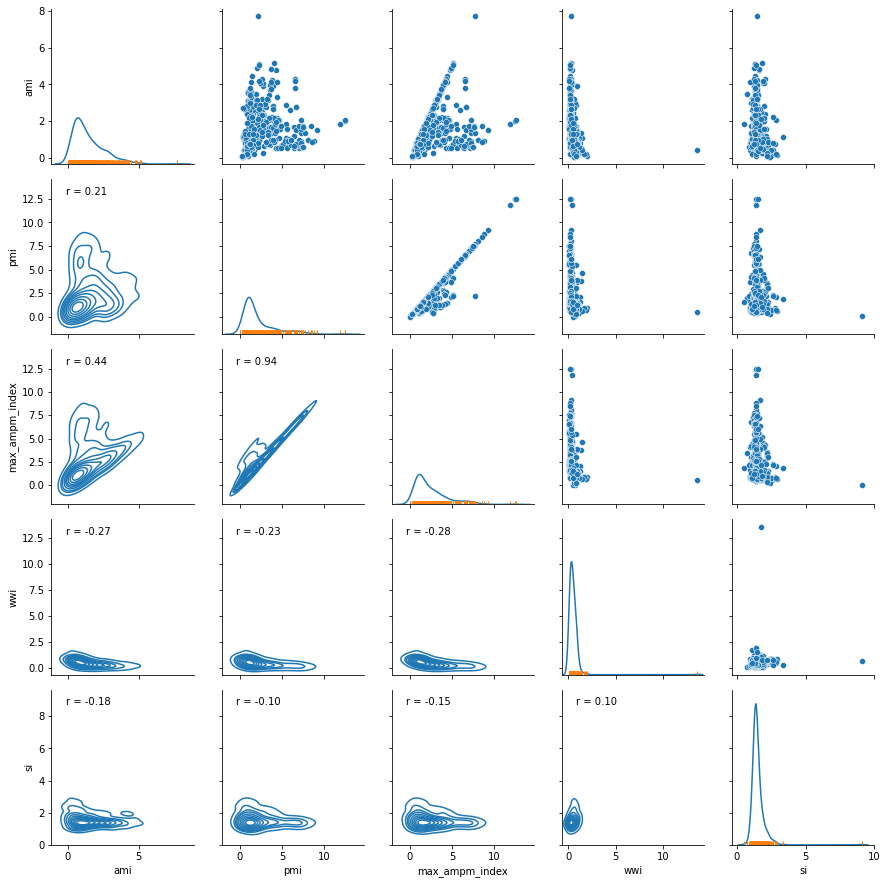

In [23]:
pairplot_path = timestamp_path(f'{pattern_img_path}/index_pairplots/{{timestamp}}/pairplot.png')
make_pairplot(count_sites[index_columns], save=False, fi_path=pairplot_path)

It looks like there are some outlier locations we would like to drop.

In [24]:
outlier_mask = (count_sites.wwi > 5) | (count_sites.si > 5)

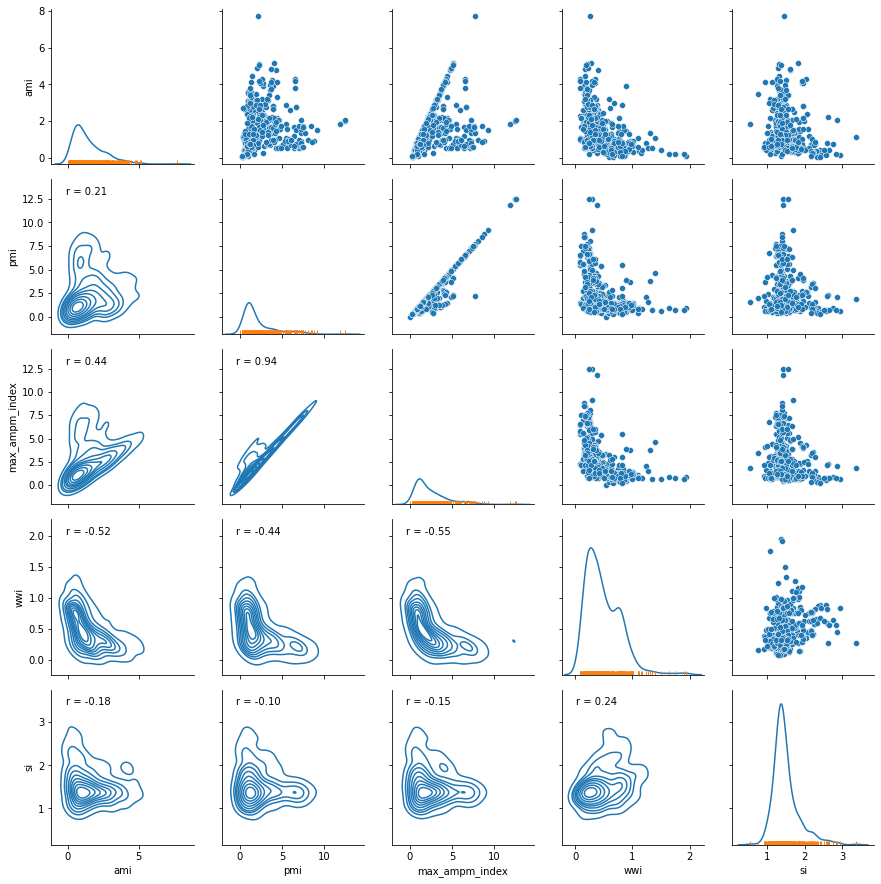

In [25]:
pairplot_no_outlier_path = timestamp_path(f'{pattern_img_path}/index_pairplots_nooutliers/{{timestamp}}/pairplot.png')
make_pairplot(count_sites[~outlier_mask][index_columns], save=False, fi_path=pairplot_no_outlier_path)

In [26]:
count_sites[~outlier_mask].explore('si', marker_kwds={'radius': 10})

<a id='feature_eng'></a>
# Feature engineering
This section contains a little feature engineering, specifically on population density.

In [1]:
# This file was downloaded directly from the Census
# it is large so should not be loaded to GitHub. The main thing it contains is the geometries.
block_groups = gpd.read_file('./ACS_2019_5YR_BG_06.gdb.zip', layer='ACS_2019_5YR_BG_06_CALIFORNIA').set_index('GEOID')
block_groups['aland_sqmi'] = block_groups['ALAND'] / (1609.*1609.)

NameError: name 'gpd' is not defined

In [35]:
with fs.open('smart4/context_data/census/ACSDT5Y2019.B01001-Data.csv') as fi:
    bg_pop = pd.read_csv(fi, skiprows=1)

bg_pop['geoid'] = bg_pop['Geography'].str[9:]
bg_pop = bg_pop.set_index('geoid')
bg_pop = bg_pop.rename(columns={'Estimate!!Total:': 'pop'})

In [36]:
block_groups = block_groups.join(bg_pop[['pop']])

In [47]:
# calculate area-weightd average population density - make this a function if needed
count_sites = count_sites.set_index(['ID', 'year'])

block_groups['popden'] = block_groups['pop']/block_groups['aland_sqmi']
block_groups = block_groups.to_crs(3310)

count_sites['buffer_geometry'] = count_sites.buffer(1609.)
count_sites = count_sites.set_geometry('buffer_geometry')

joined_geos = count_sites[['buffer_geometry']].\
    sjoin(block_groups[['geometry']]).\
    join(block_groups[['geometry']], on='index_right')

joined_geos['overlap'] = joined_geos['buffer_geometry'].intersection(joined_geos['geometry']).area

joined_geos['overlap_ratio'] = joined_geos['overlap']/(joined_geos['buffer_geometry'].area)

joined_geos = joined_geos.join(block_groups[['popden']], on='index_right')

joined_geos['weighted_popden'] = joined_geos['overlap_ratio'] * joined_geos['popden']

count_sites['popden'] = joined_geos.groupby(['ID', 'year'])['weighted_popden'].sum()

In [48]:
count_sites = count_sites.set_geometry('geometry').drop(columns='buffer_geometry')

### Evaluate predictors

In [69]:
predictor_cols = ['popden', 'stv_total', 'stv_com_to', 'stv_rec_to', 'stv_rec_ra']

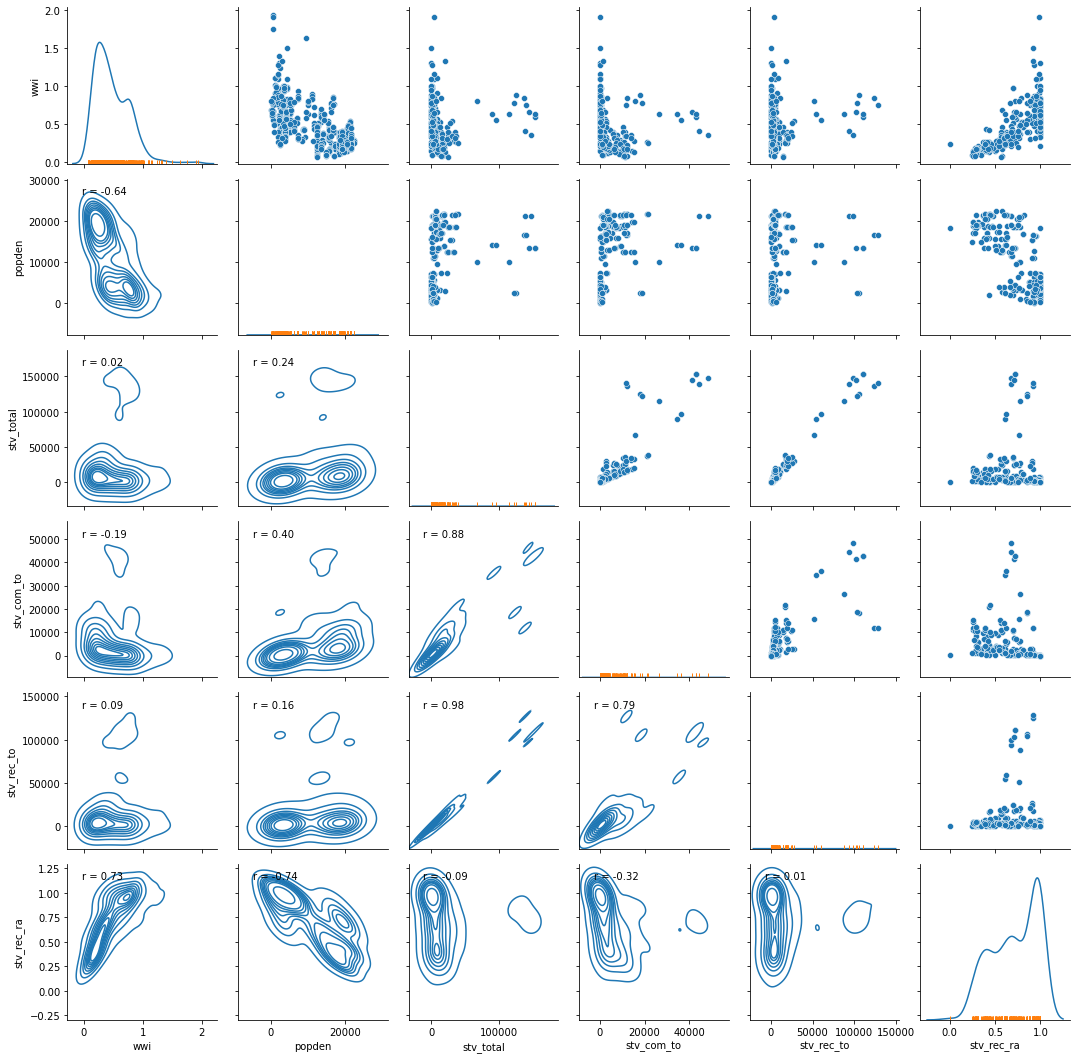

In [70]:
make_pairplot(count_sites[count_sites.wwi < 10][['wwi'] + predictor_cols])

Plot saved to 'smart4/count_patterns/img/wwi_predictors/2022-11-07T06:19:26.986567-08:00/scatterplot.png'


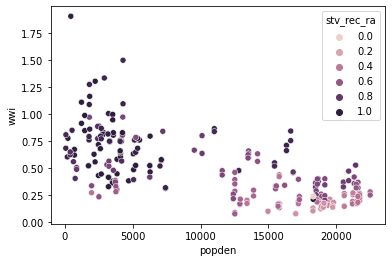

In [78]:
wwi_predictors_path = timestamp_path(f'{pattern_img_path}/wwi_predictors/{{timestamp}}/scatterplot.png')
fig, ax = plt.subplots()
sns.scatterplot(data=count_sites[count_sites.wwi < 10], x='popden', y='wwi', hue='stv_rec_ra')
save_plot_gcs(fig, wwi_predictors_path)

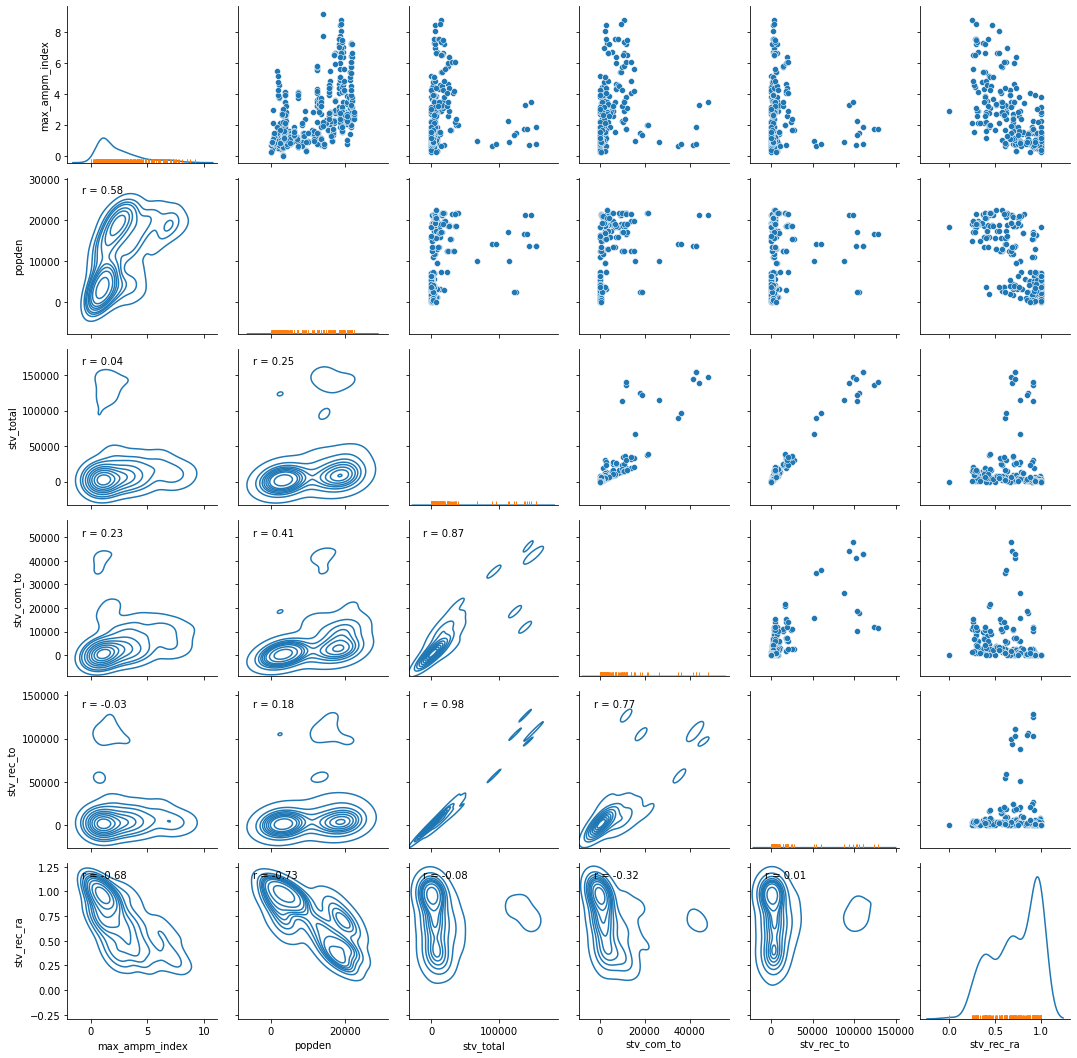

In [73]:
make_pairplot(count_sites[count_sites.max_ampm_index < 10][['max_ampm_index'] + predictor_cols])

Plot saved to 'smart4/count_patterns/img/hod_index_predictors/2022-11-07T06:18:49.907564-08:00/scatterplot.png'


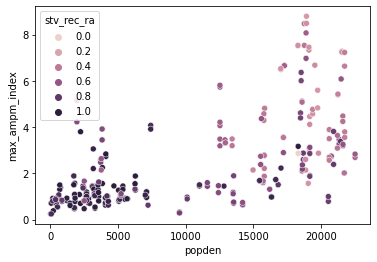

In [77]:
ampm_index_predictors_path = timestamp_path(f'{pattern_img_path}/hod_index_predictors/{{timestamp}}/scatterplot.png')
fig, ax = plt.subplots()
sns.scatterplot(data=count_sites[count_sites.max_ampm_index < 10], x='popden', y='max_ampm_index', hue='stv_rec_ra')
save_plot_gcs(fig, ampm_index_predictors_path)